In [1]:
import numpy as np
import time
import math
from importlib.machinery import SourceFileLoader
import matplotlib.pyplot as plt
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]='5'
import tensorflow as tf
import tensorflow_probability as tfp

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-06-09 14:36:16.011934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 14:36:17.180803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2024-06-09 14:36:19.906551: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-09 14:36:19.906613: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: hm01.dice.priv
2024-06-09 14:36:19.906620: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: hm01.dice.priv
2024-06-09 14:36:19.906752: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.15
2024-06-09 14:36:19.906815: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 525.85.12
2024-06-09 14:36:19.906824: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 525.85.12 does not match DSO version 550.54.15 -- cannot find working devices in this configuration


# Basic

In [2]:
@tf.function(reduce_retracing=True)
def norm_pdf(x, pdf):
    # Flatten the tensors for sorting purposes
    x_flat = tf.reshape(x, [-1])
    y_flat = tf.reshape(pdf(x), [-1])

    # Get the sorted indices and sort both x and y
    sorted_indices = tf.argsort(x_flat)
    sorted_x = tf.gather(x_flat, sorted_indices)
    sorted_y = tf.gather(y_flat, sorted_indices)

    # Perform integration using tfp.math.trapz along the second axis
    norm_const = tfp.math.trapz(sorted_y, sorted_x)

    a = tf.convert_to_tensor(pdf(x)/norm_const)

    return a


@tf.function(reduce_retracing=True)
def int(x, pdf):
    array = pdf(x) 
    norm_const = tfp.math.trapz(pdf(x), x)
    tf.print(norm_const)
    return array/norm_const

In [3]:

Bu_M = tf.linspace(5080.0, 5800.0, 20000, name='Bu_M')

# HORNSdini

In [4]:
_PI = tf.cast(math.pi, tf.float32)
@tf.function
def HORNSdini(m, a, b, csi, shift, sigma, ratio_sigma, fraction_sigma):

    a_new = tf.cast(a, tf.float32)
    b_new = tf.cast(b, tf.float32)
    B_NEW = (a_new + b_new) / 2.0
    sigma2 = tf.cast(sigma * ratio_sigma, tf.float32)

    firstG1 = ((2.0*(a_new-2.0*B_NEW+(m-shift))*sigma)/tf.math.exp((a_new-(m-shift))*(a_new-(m-shift))/(2.0*sigma*sigma)) - (2.0*(b_new-2.0*B_NEW+(m-shift))*sigma)/tf.math.exp((b_new-(m-shift))*(b_new-(m-shift))/(2.0*sigma*sigma))+ tf.math.sqrt(2.0*_PI)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma)*tf.math.erf((-a_new+(m-shift))/(tf.math.sqrt(2.0)*sigma))  - tf.math.sqrt(2.0*_PI)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma) * tf.math.erf((-b_new+(m-shift))/(tf.math.sqrt(2.0)*sigma)))/(2.0*tf.math.sqrt(2.0*_PI))
    secondG1 = (((2.0*sigma*(a_new*a_new + B_NEW*B_NEW + a_new*(m-shift) + (m-shift)*(m-shift) - 2.0*B_NEW*(a_new+(m-shift)) + 2.0*(sigma*sigma)))/tf.math.exp((a_new-(m-shift))*(a_new-(m-shift))/(2.0*(sigma*sigma))) - (2.0*sigma*(b_new*b_new + B_NEW*B_NEW + b_new*(m-shift) + (m-shift)*(m-shift) - 2.0*B_NEW*(b_new + (m-shift)) + 2.0*(sigma*sigma)))/tf.math.exp((b_new - (m-shift))*(b_new - (m-shift))/(2.0*(sigma*sigma))) - tf.math.sqrt(2.0*_PI)*(-((B_NEW - (m-shift))*(B_NEW - (m-shift)) *(m-shift)) + (2.0*B_NEW - 3*(m-shift))*(sigma*sigma))*tf.math.erf((-a_new + (m-shift))/(tf.math.sqrt(2.0)*sigma)) + tf.math.sqrt(2.0*_PI)* (-((B_NEW - (m-shift))*(B_NEW - (m-shift))*(m-shift)) + (2.0*B_NEW - 3*(m-shift))*(sigma*sigma)) *tf.math.erf((-b_new + (m-shift))/(tf.math.sqrt(2.0)*sigma)))/(2 *tf.math.sqrt(2.0*_PI)))

    CURVEG1 = tf.math.abs((1-csi)*secondG1 + (b_new*csi - a_new)*firstG1)

    firstG2 = ((2.0*(a_new-2.0*B_NEW+(m-shift))*sigma2)/tf.math.exp((a_new-(m-shift))*(a_new-(m-shift))/(2.0*sigma2**2)) - (2.0*(b_new-2.0*B_NEW+(m-shift))*sigma2)/tf.math.exp((b_new-(m-shift))*(b_new-(m-shift))/(2.0*sigma2**2))+ tf.math.sqrt(2.0*_PI)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma2**2)*tf.math.erf((-a_new+(m-shift))/(tf.math.sqrt(2.0)*sigma2))  - tf.math.sqrt(2.0*_PI)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma2**2) * tf.math.erf((-b_new+(m-shift))/(tf.math.sqrt(2.0)*sigma2)))/(2.0*tf.math.sqrt(2.0*_PI))
    secondG2 = (((2.0*sigma2*(a_new*a_new + B_NEW*B_NEW + a_new*(m-shift) + (m-shift)*(m-shift) - 2.0*B_NEW*(a_new+(m-shift)) + 2.0*(sigma2**2)))/tf.math.exp((a_new-(m-shift))*(a_new-(m-shift))/(2.0*(sigma2**2))) - (2.0*sigma2*(b_new*b_new + B_NEW*B_NEW + b_new*(m-shift) + (m-shift)*(m-shift) - 2.0*B_NEW*(b_new + (m-shift)) + 2.0*(sigma2**2)))/tf.math.exp((b_new - (m-shift))*(b_new - (m-shift))/(2.0*(sigma2**2))) - tf.math.sqrt(2.0*_PI)*(-((B_NEW - (m-shift))*(B_NEW - (m-shift)) *(m-shift)) + (2.0*B_NEW - 3*(m-shift))*(sigma2**2))*tf.math.erf((-a_new + (m-shift))/(tf.math.sqrt(2.0)*sigma2)) + tf.math.sqrt(2.0*_PI)* (-((B_NEW - (m-shift))*(B_NEW - (m-shift))*(m-shift)) + (2.0*B_NEW - 3*(m-shift))*(sigma2**2)) *tf.math.erf((-b_new + (m-shift))/(tf.math.sqrt(2.0)*sigma2)))/(2 *tf.math.sqrt(2.0*_PI)))

    CURVEG2 = tf.math.abs((1-csi)*secondG2 + (b_new*csi - a_new)*firstG2)
    return (fraction_sigma*CURVEG1 + (1-fraction_sigma)*CURVEG2)


    

In [5]:
varDict['low_sigma_k_DD'] = varDict['low_sigma_pi_DD']/varDict['low_sigma_pi_over_k_ratio']
varDict['low_sigma_k_LL'] = varDict['low_sigma_pi_LL']/varDict['low_sigma_pi_over_k_ratio']


pdf_Bu_Dstar0h_D0pi0_DK_Kspipi_LL =  lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])

Text(0, 0.5, 'A.U.')

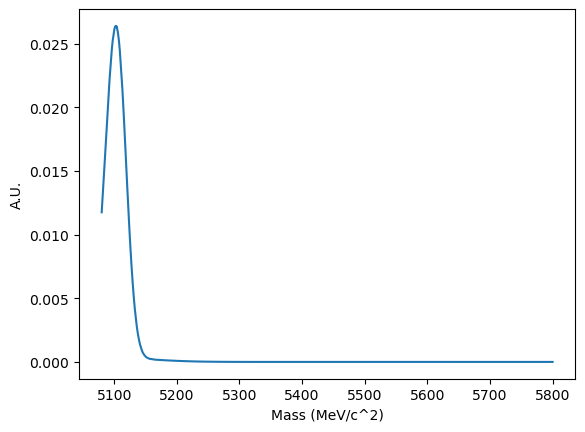

In [6]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_Kspipi_LL), label='HORNSdini')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')

# Cruijffextended

In [7]:
@tf.function
def CruijffExtended(m, m0, sigmaL, sigmaR, alphaL, alphaR, beta):
    sigma = 0.0
    alpha = 0.0
    dx = m - m0

    sigma = tf.where(dx < 0.0, sigmaL, sigmaR)
    alpha = tf.where(dx < 0.0, alphaL, alphaR)

    f = 2.0*sigma*sigma + alpha*dx*dx
    return tf.exp(-dx**2 *(1 + beta * dx **2)/f)  

In [8]:
pdf_sig_Cruijff_DK_KsPiPi_DD = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])


Text(0, 0.5, 'A.U.')

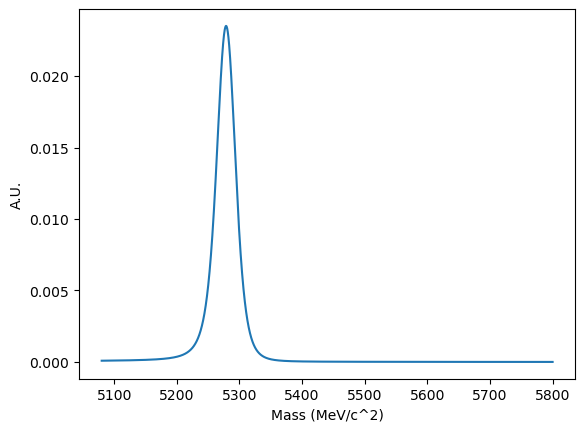

In [9]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_sig_Cruijff_DK_KsPiPi_DD), label='Cruijff')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')

# HORNSdini_misID

In [10]:
@tf.function
def HORNSdini_misID(m,a,b,csi,m1,s1,m2,s2,m3,s3,m4,s4,f1,f2,f3):
    a_new = tf.cast(a, tf.float32)
    b_new = tf.cast(b, tf.float32)
    B_NEW = (a_new + b_new) / 2.0


    firstG1 = ((2.0 * (a_new - 2.0 * B_NEW + (m - m1)) * s1) / tf.math.exp((a_new - (m - m1)) **2 / (2.0 * s1**2 )) - (2.0 * (b_new - 2.0 * B_NEW + (m - m1)) * s1) / tf.math.exp((b_new - (m - m1)) **2 / (2.0 * (s1 **2))) + tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m1)) **2 + s1 ** 2) * tf.math.erf((-a_new + (m - m1)) / (tf.math.sqrt(2.0) * s1)) - tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m1)) ** 2 + s1 **2) * tf.math.erf((-b_new + (m - m1)) / (tf.math.sqrt(2.0) * s1))) / (2.0 * tf.math.sqrt(2.0 * _PI))
    secondG1 = (((2*s1*(a_new**2 + B_NEW**2 + a_new*(m-m1) + (m-m1)**2 - 2*B_NEW*(a_new+(m-m1)) + 2*s1**2 ))/tf.math.exp((a_new-(m-m1))**2 /(2.0*(s1**2))) - (2*s1*(b_new**2 + B_NEW**2 + b_new*(m-m1) + (m-m1)**2 - 2*B_NEW*(b_new + (m-m1)) + 2*(s1**2)))/tf.math.exp((b_new - (m-m1))**2 /(2.0*(s1**2))) - tf.math.sqrt(2*_PI)*(-((B_NEW - (m-m1))**2.0 *(m-m1)) + (2*B_NEW - 3*(m-m1))*(s1**2))*tf.math.erf((-a_new + (m-m1))/(tf.math.sqrt(2.0)*s1)) + tf.math.sqrt(2*_PI)* (-((B_NEW - (m-m1))**2.0 *(m-m1)) + (2*B_NEW - 3*(m-m1))*(s1**2)) *tf.math.erf((-b_new + (m-m1))/(tf.math.sqrt(2.0)*s1)))/(2.0 *tf.math.sqrt(2*_PI)))
    CURVEG1 = tf.math.abs((1-csi)*secondG1 + (b_new*csi - a_new)*firstG1)

    firstG2 = ((2.0 * (a_new - 2.0 * B_NEW + (m - m2)) * s2) / tf.math.exp((a_new - (m - m2)) **2 / (2.0 * s2**2 )) - (2.0 * (b_new - 2.0 * B_NEW + (m - m2)) * s2) / tf.math.exp((b_new - (m - m2)) **2 / (2.0 * (s2 **2))) + tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m2)) **2 + s2 ** 2) * tf.math.erf((-a_new + (m - m2)) / (tf.math.sqrt(2.0) * s2)) - tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m2)) ** 2 + s2**2) * tf.math.erf((-b_new + (m - m2)) / (tf.math.sqrt(2.0) * s2))) / (2.0 * tf.math.sqrt(2.0 * _PI))
    secondG2 = (((2*s2*(a_new**2 + B_NEW**2 + a_new*(m-m2) + (m-m2)**2 - 2*B_NEW*(a_new+(m-m2)) + 2*s2**2 ))/tf.math.exp((a_new-(m-m2))**2 /(2.0*(s2**2))) - (2*s2*(b_new**2 + B_NEW**2 + b_new*(m-m2) + (m-m2)**2 - 2*B_NEW*(b_new + (m-m2)) + 2*(s2**2)))/tf.math.exp((b_new - (m-m2))**2 /(2.0*(s2**2))) - tf.math.sqrt(2*_PI)*(-((B_NEW - (m-m2))**2.0 *(m-m2)) + (2*B_NEW - 3*(m-m2))*(s2**2))*tf.math.erf((-a_new + (m-m2))/(tf.math.sqrt(2.0)*s2)) + tf.math.sqrt(2*_PI)* (-((B_NEW - (m-m2))**2.0 *(m-m2)) + (2*B_NEW - 3*(m-m2))*(s2**2)) *tf.math.erf((-b_new + (m-m2))/(tf.math.sqrt(2.0)*s2)))/(2.0 *tf.math.sqrt(2*_PI)))
    CURVEG2 = tf.math.abs((1-csi)*secondG2 + (b_new*csi - a_new)*firstG2)

    firstG3 = ((2.0 * (a_new - 2.0 * B_NEW + (m - m3)) * s3) / tf.math.exp((a_new - (m - m3)) **2 / (2.0 * s3**2 )) - (2.0 * (b_new - 2.0 * B_NEW + (m - m3)) * s3) / tf.math.exp((b_new - (m - m3)) **2 / (2.0 * (s3 **2))) + tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m3)) **2 + s3 ** 2) * tf.math.erf((-a_new + (m - m3)) / (tf.math.sqrt(2.0) * s3)) - tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m3)) ** 2 + s3 **2) * tf.math.erf((-b_new + (m - m3)) / (tf.math.sqrt(2.0) * s3))) / (2.0 * tf.math.sqrt(2.0 * _PI))
    secondG3 = (((2*s3*(a_new**2 + B_NEW**2 + a_new*(m-m3) + (m-m3)**2 - 2*B_NEW*(a_new+(m-m3)) + 2*s3**2 ))/tf.math.exp((a_new-(m-m3))**2 /(2.0*(s3**2))) - (2*s3*(b_new**2 + B_NEW**2 + b_new*(m-m3) + (m-m3)**2 - 2*B_NEW*(b_new + (m-m3)) + 2*(s3**2)))/tf.math.exp((b_new - (m-m3))**2 /(2.0*(s3**2))) - tf.math.sqrt(2*_PI)*(-((B_NEW - (m-m3))**2.0 *(m-m3)) + (2*B_NEW - 3*(m-m3))*(s3**2))*tf.math.erf((-a_new + (m-m3))/(tf.math.sqrt(2.0)*s3)) + tf.math.sqrt(2*_PI)* (-((B_NEW - (m-m3))**2.0 *(m-m3)) + (2*B_NEW - 3*(m-m3))*(s3**2)) *tf.math.erf((-b_new + (m-m3))/(tf.math.sqrt(2.0)*s3)))/(2.0 *tf.math.sqrt(2*_PI)))
    CURVEG3 = tf.math.abs((1-csi)*secondG3 + (b_new*csi - a_new)*firstG3)

    firstG4 = ((2.0 * (a_new - 2.0 * B_NEW + (m - m4)) * s4) / tf.math.exp((a_new - (m - m4)) **2 / (2.0 * s4**2 )) - (2.0 * (b_new - 2.0 * B_NEW + (m - m4)) * s4) / tf.math.exp((b_new - (m - m4)) **2 / (2.0 * (s4 **2))) + tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m4)) **2 + s4 ** 2) * tf.math.erf((-a_new + (m - m4)) / (tf.math.sqrt(2.0) * s4)) - tf.math.sqrt(2.0 * _PI) * ((B_NEW - (m - m4)) ** 2 + s4 **2) * tf.math.erf((-b_new + (m - m4)) / (tf.math.sqrt(2.0) * s4))) / (2.0 * tf.math.sqrt(2.0 * _PI))
    secondG4 = (((2*s4*(a_new**2 + B_NEW**2 + a_new*(m-m4) + (m-m4)**2 - 2*B_NEW*(a_new+(m-m4)) + 2*s4**2 ))/tf.math.exp((a_new-(m-m4))**2 /(2.0*(s4**2))) - (2*s4*(b_new**2 + B_NEW**2 + b_new*(m-m4) + (m-m4)**2 - 2*B_NEW*(b_new + (m-m4)) + 2*(s4**2)))/tf.math.exp((b_new - (m-m4))**2 /(2.0*(s4**2))) - tf.math.sqrt(2*_PI)*(-((B_NEW - (m-m4))**2.0 *(m-m4)) + (2*B_NEW - 3*(m-m4))*(s4**2))*tf.math.erf((-a_new + (m-m4))/(tf.math.sqrt(2.0)*s4)) + tf.math.sqrt(2*_PI)* (-((B_NEW - (m-m4))**2.0 *(m-m4)) + (2*B_NEW - 3*(m-m4))*(s4**2)) *tf.math.erf((-b_new + (m-m4))/(tf.math.sqrt(2.0)*s4)))/(2.0 *tf.math.sqrt(2*_PI)))
    CURVEG4 = tf.math.abs((1-csi)*secondG4 + (b_new*csi - a_new)*firstG4)


    return tf.math.abs(f1*CURVEG1) + tf.math.abs(f2*CURVEG2) + tf.math.abs(f3*CURVEG3) + tf.math.abs((1-f1-f2-f3)*CURVEG4)

In [11]:
pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])

Text(0, 0.5, 'A.U.')

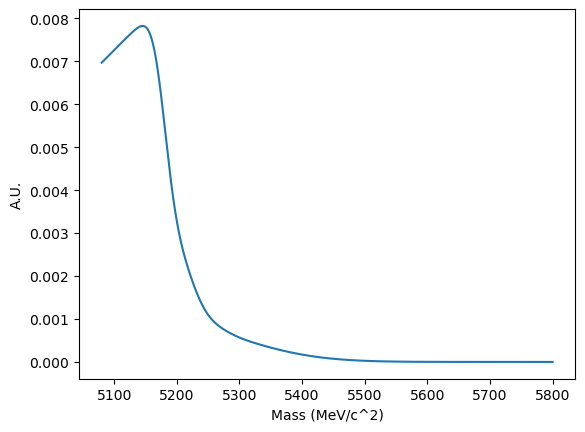

In [12]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL), label='HORNSdini_misID')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')

# Crystle Ball

In [13]:
@tf.function
def CBShape(m,m0,sigma,alpha,n):
   t =(m-m0)/sigma

   if alpha <0:
      t = -t
   else:
      t = t

   absAlpha = tf.math.abs(alpha) 
   val_a = tf.math.exp(-0.5*t*t)
   
   a =  tf.math.pow(n/absAlpha,n)*tf.math.exp(-0.5*absAlpha*absAlpha)
   b= n/absAlpha - absAlpha
   val_b = a/tf.math.pow(b-t, n)

   val = tf.where(t >= -absAlpha, val_a, val_b)
   return val

In [14]:
pdf_misid_CB1_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width1'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha1'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])

Text(0, 0.5, 'A.U.')

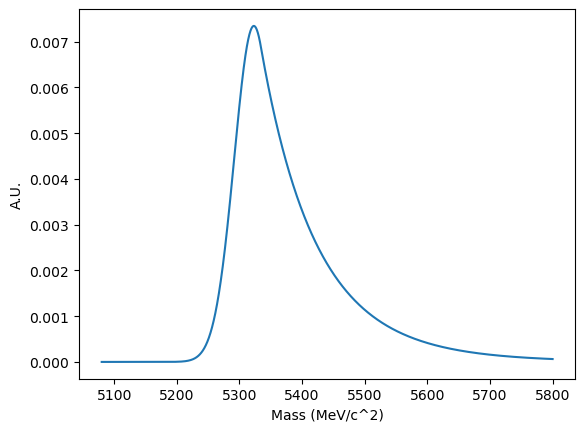

In [15]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_misid_CB1_DK_KsPiPi_LL), label='CBShape')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')

# Exponential

In [16]:
@tf.function 
def Exponential(m, c):
    c = tf.cast(c, tf.float32)
    return tf.math.exp(c*m)

In [17]:
varDict['comb_const_dpi_d2kspp_LL']

-0.0033430512804623093

In [18]:
pdf_comb_DPi_KsPiPi_LL = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_LL'])


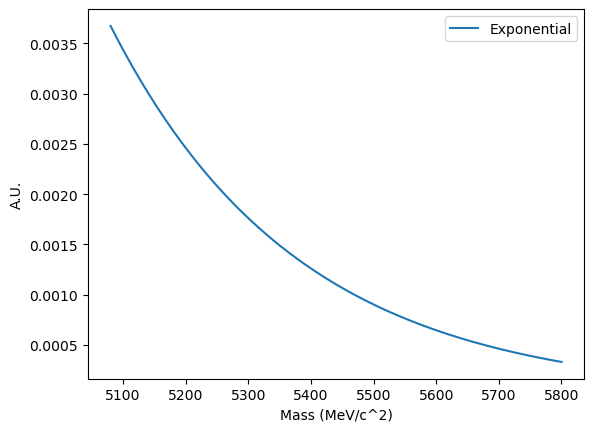

In [19]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_comb_DPi_KsPiPi_LL), label='Exponential')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')
plt.legend()


# Guassian

In [20]:
@tf.function 
def Gaussian(m, mu, sigma):
    mu = tf.cast(mu, dtype=tf.float32)
    sigma = tf.cast(sigma, dtype=tf.float32)
    return (tf.math.exp(-0.5*((m-mu)/sigma)**2))/(sigma*tf.math.sqrt(2.0*_PI))

In [21]:
pdf_sig_Gauss_DK_KsPiPi_DD = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'])

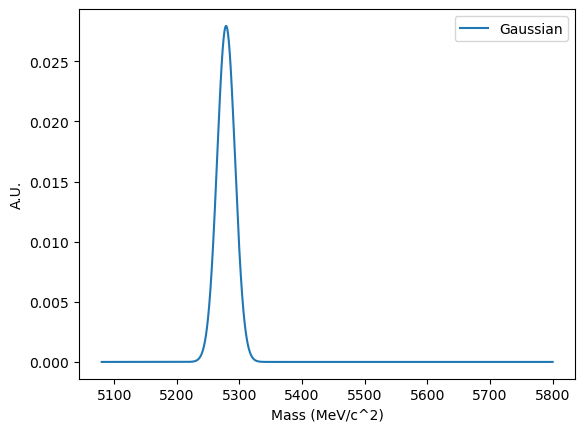

In [22]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_sig_Gauss_DK_KsPiPi_DD), label='Gaussian')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')
plt.legend()

# HILLdini

In [23]:
@tf.function 
def HILLdini(m,a,b,csi,shift,sigma,ratio_sigma,fraction_sigma):
    a_new = tf.cast(a, tf.float32)
    b_new = tf.cast(b, tf.float32)
    sigma = tf.cast(sigma, tf.float32)
    shift = tf.cast(shift, tf.float32)
    csi = tf.cast(csi, tf.float32)
    fraction_sigma = tf.cast(fraction_sigma, tf.float32)
    ratio_sigma = tf.cast(ratio_sigma, tf.float32)
    sigma2 = sigma * ratio_sigma

    firstG1 = (2.0*tf.math.exp(-((a_new-(m-shift))*(a_new-(m-shift))/(2.0*(sigma*sigma))))*sigma*(b_new-(m-shift))+2.0*tf.math.exp(-((b_new-(m-shift))*(b_new-(m-shift))/(2.0*(sigma*sigma))))*sigma*(-a_new+(m-shift))-tf.math.sqrt(2.0*_PI)*(a_new*b_new+(sigma*sigma)-(a_new+b_new)*(m-shift)+((m-shift)*(m-shift)))*tf.math.erf((-a_new+(m-shift))/(tf.math.sqrt(2.0)*sigma))+tf.math.sqrt(2.0*_PI)*(a_new*b_new+(sigma*sigma)-(a_new+b_new)*(m-shift)+((m-shift)*(m-shift)))*tf.math.erf((-b_new+(m-shift))/(tf.math.sqrt(2.0)*sigma)))/(2.0*tf.math.sqrt(2.0*_PI))
    CURVEG1 = tf.math.abs((1-csi)/(b_new - a_new)*m + (b_new*csi - a_new)/(b_new-a_new))*tf.math.abs(firstG1)

    firstG2 = (2.0*tf.math.exp(-((a_new-(m-shift))*(a_new-(m-shift))/(2.0*(sigma2*sigma2))))*sigma2*(b_new-(m-shift))+2.0*tf.math.exp(-((b_new-(m-shift))*(b_new-(m-shift))/(2.0*(sigma2*sigma2))))*sigma2*(-a_new+(m-shift))-tf.math.sqrt(2.0*_PI)*(a_new*b_new+(sigma2*sigma2)-(a_new+b_new)*(m-shift)+((m-shift)*(m-shift)))*tf.math.erf((-a_new+(m-shift))/(tf.math.sqrt(2.0)*sigma2))+tf.math.sqrt(2.0*_PI)*(a_new*b_new+(sigma2*sigma2)-(a_new+b_new)*(m-shift)+((m-shift)*(m-shift)))*tf.math.erf((-b_new+(m-shift))/(tf.math.sqrt(2.0)*sigma2)))/(2.0*tf.math.sqrt(2.0*_PI))
    CURVEG2 = tf.math.abs((1-csi)/(b_new - a_new)*m + (b_new*csi - a_new)/(b_new-a_new))*tf.math.abs(firstG2)

    return tf.math.abs(fraction_sigma*CURVEG1) + tf.math.abs((1-fraction_sigma)*CURVEG2)


In [24]:
pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])

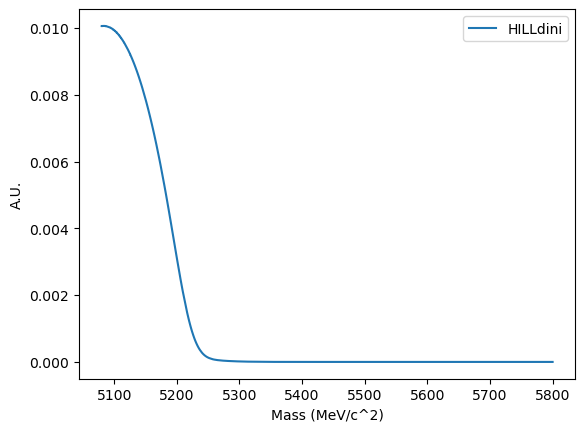

In [25]:
plt.plot(Bu_M, norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL), label='HILLdini')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')
plt.legend()

# HILLdini_MisID

In [26]:
@tf.function
def HILLdini_misID(m,a,b,csi,m1,s1,m2,s2,m3,s3,m4,s4,f1,f2,f3):
    a_new = tf.cast(a, tf.float32)
    b_new = tf.cast(b, tf.float32)
    m1 = tf.cast(m1, tf.float32)
    s1 = tf.cast(s1, tf.float32)
    m2 = tf.cast(m2, tf.float32)
    s2 = tf.cast(s2, tf.float32)
    m3 = tf.cast(m3, tf.float32)
    s3 = tf.cast(s3, tf.float32)
    m4 = tf.cast(m4, tf.float32)
    s4 = tf.cast(s4, tf.float32)
    f1 = tf.cast(f1, tf.float32)
    f2 = tf.cast(f2, tf.float32)
    f3 = tf.cast(f3, tf.float32)

    firstG1 = (2.0*tf.math.exp(-((a_new-(m-m1))*(a_new-(m-m1))/(2.0*(s1*s1))))*s1*(b_new-(m-m1))+2.0*tf.math.exp(-((b_new-(m-m1))*(b_new-(m-m1))/(2.0*(s1*s1))))*s1*(-a_new+(m-m1))-tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s1*s1)-(a_new+b_new)*(m-m1)+((m-m1)*(m-m1)))*tf.math.erf((-a_new+(m-m1))/(tf.math.sqrt(2.0)*s1))+tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s1*s1)-(a_new+b_new)*(m-m1)+((m-m1)*(m-m1)))*tf.math.erf((-b_new+(m-m1))/(tf.math.sqrt(2.0)*s1)))/(2*tf.math.sqrt(2.0*_PI))
    CURVEG1 = tf.math.abs((1-csi)/(b_new-a_new)*(m-m1)  + (b_new*csi - a_new)/(b_new-a_new)  )*tf.math.abs(firstG1)

    firstG2 = (2.0*tf.math.exp(-((a_new-(m-m2))*(a_new-(m-m2))/(2.0*(s2*s2))))*s2*(b_new-(m-m2))+2.0*tf.math.exp(-((b_new-(m-m2))*(b_new-(m-m2))/(2.0*(s2*s2))))*s2*(-a_new+(m-m2))-tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s2*s2)-(a_new+b_new)*(m-m2)+((m-m2)*(m-m2)))*tf.math.erf((-a_new+(m-m2))/(tf.math.sqrt(2.0)*s2))+tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s2*s2)-(a_new+b_new)*(m-m2)+((m-m2)*(m-m2)))*tf.math.erf((-b_new+(m-m2))/(tf.math.sqrt(2.0)*s2)))/(2*tf.math.sqrt(2.0*_PI))
    CURVEG2 = tf.math.abs((1-csi)/(b_new-a_new)*(m-m2)  + (b_new*csi - a_new)/(b_new-a_new)  )*tf.math.abs(firstG2)

    firstG3 = (2.0*tf.math.exp(-((a_new-(m-m3))*(a_new-(m-m3))/(2.0*(s3*s3))))*s3*(b_new-(m-m3))+2.0*tf.math.exp(-((b_new-(m-m3))*(b_new-(m-m3))/(2.0*(s3*s3))))*s3*(-a_new+(m-m3))-tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s3*s3)-(a_new+b_new)*(m-m3)+((m-m3)*(m-m3)))*tf.math.erf((-a_new+(m-m3))/(tf.math.sqrt(2.0)*s3))+tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s3*s3)-(a_new+b_new)*(m-m3)+((m-m3)*(m-m3)))*tf.math.erf((-b_new+(m-m3))/(tf.math.sqrt(2.0)*s3)))/(2*tf.math.sqrt(2.0*_PI))
    CURVEG3 = tf.math.abs((1-csi)/(b_new-a_new)*(m-m3)  + (b_new*csi - a_new)/(b_new-a_new)  )*tf.math.abs(firstG3)

    firstG4 = (2.0*tf.math.exp(-((a_new-(m-m4))*(a_new-(m-m4))/(2.0*(s4*s4))))*s4*(b_new-(m-m4))+2.0*tf.math.exp(-((b_new-(m-m4))*(b_new-(m-m4))/(2.0*(s4*s4))))*s4*(-a_new+(m-m4))-tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s4*s4)-(a_new+b_new)*(m-m4)+((m-m4)*(m-m4)))*tf.math.erf((-a_new+(m-m4))/(tf.math.sqrt(2.0)*s4))+tf.math.sqrt(2.0*_PI)*(a_new*b_new+(s4*s4)-(a_new+b_new)*(m-m4)+((m-m4)*(m-m4)))*tf.math.erf((-b_new+(m-m4))/(tf.math.sqrt(2.0)*s4)))/(2*tf.math.sqrt(2.0*_PI))
    CURVEG4 = tf.math.abs((1-csi)/(b_new-a_new)*(m-m4)  + (b_new*csi - a_new)/(b_new-a_new)  )*tf.math.abs(firstG4)

    return tf.math.abs(f1*CURVEG1) + tf.math.abs(f2*CURVEG2) + tf.math.abs(f3*CURVEG3) + tf.math.abs((1-f1-f2-f3)*CURVEG4)


In [27]:
pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])

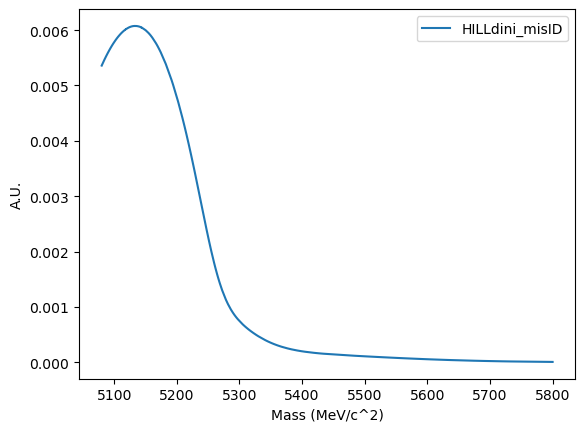

In [28]:
#plot 

plt.plot(Bu_M, norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL), label='HILLdini_misID')
plt.xlabel('Mass (MeV/c^2)')
plt.ylabel('A.U.')
plt.legend()
plt.show()

In [35]:
import sys
sys.path.append('/software/pc24403/tfpcbpggsz/func')
from tfmassshape import *

In [39]:
def preparePdf_data(Bu_M, varDict, mode='b2dk_LL'):
    '''
    Import constructed data sets and construct PDFs with RooFit functions.
    PDFs and data sets are saved together in a new RooWorkspace

    Args:
        configDict: a dictionary containing the values of PDF shape parameters
        year: which subset of data to fit, can be any single year of data taking,
              or 'Run1', 'Run2', 'All'.
    ''' 

    pdfList = {}

    print('--- Constructing signal pdfs...')
    varDict['DD_dk_Gauss_frac'] = 1 - varDict['DD_dk_Cruijff_frac']
    varDict['DD_dpi_Gauss_frac'] = 1- varDict['DD_dpi_Cruijff_frac']
    varDict['LL_dk_Gauss_frac'] = 1 - varDict['LL_dk_Cruijff_frac']
    varDict['LL_dpi_Gauss_frac'] = 1 - varDict['LL_dpi_Cruijff_frac']

    pdf_sig_Cruijff_DK_KsPiPi_DD  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_DD    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'])

    pdf_sig_Cruijff_DPi_KsPiPi_DD = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'], varDict['sigma_dpi_DD'], varDict['DD_dpi_Cruijff_alpha_L'], varDict['DD_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_DD   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'])
    pdf_sig_Cruijff_DK_KsPiPi_LL  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'], varDict['sigma_dk_LL'], varDict['LL_dk_Cruijff_alpha_L'], varDict['LL_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_LL    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'])
    pdf_sig_Cruijff_DPi_KsPiPi_LL = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'], varDict['sigma_dpi_LL'], varDict['LL_dpi_Cruijff_alpha_L'], varDict['LL_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_LL   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'])


    if mode == 'b2dk_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DK_KsPiPi_LL) * varDict['LL_dk_Cruijff_frac'] +  norm_pdf(Bu_M, pdf_sig_Gauss_DK_KsPiPi_LL) * varDict['LL_dk_Gauss_frac'])
    elif mode == 'b2dpi_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DPi_KsPiPi_LL) * varDict['LL_dpi_Cruijff_frac'] +   norm_pdf(Bu_M, pdf_sig_Gauss_DPi_KsPiPi_LL) *  varDict['LL_dpi_Gauss_frac'])
    elif mode == 'b2dk_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DK_KsPiPi_DD) * varDict['DD_dk_Cruijff_frac'] +   norm_pdf(Bu_M, pdf_sig_Gauss_DK_KsPiPi_DD) *  varDict['DD_dk_Gauss_frac'])
    elif mode == 'b2dpi_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DPi_KsPiPi_DD) * varDict['DD_dpi_Cruijff_frac'] +  norm_pdf(Bu_M, pdf_sig_Gauss_DPi_KsPiPi_DD) * varDict['DD_dpi_Gauss_frac'])    
 

    print('--- Constructing misID pdfs...')
    pdf_misid_CB1_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width1'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha1'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width2'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha2'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB1_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width1'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha1'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width2'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha2'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB_DPi_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_dk_to_dpi_misID_mean1'], varDict['DD_dk_to_dpi_misID_width1'], varDict['DD_dk_to_dpi_misID_alpha1'], varDict['DD_dk_to_dpi_misID_n1'])
    pdf_misid_CB_DPi_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_dk_to_dpi_misID_mean1'], varDict['LL_dk_to_dpi_misID_width1'], varDict['LL_dk_to_dpi_misID_alpha1'], varDict['LL_dk_to_dpi_misID_n1'])
    if mode == 'b2dk_LL':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_misid_CB1_DK_KsPiPi_LL) * varDict['LL_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(Bu_M, pdf_misid_CB2_DK_KsPiPi_LL) * varDict['LL_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dk_DD':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_misid_CB1_DK_KsPiPi_DD) * varDict['DD_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(Bu_M, pdf_misid_CB2_DK_KsPiPi_DD) * varDict['DD_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dpi_LL':
        pdfList['misid'] = lambda Bu_M: norm_pdf(Bu_M, pdf_misid_CB_DPi_KsPiPi_LL) 
    elif mode == 'b2dpi_DD':
        pdfList['misid'] = lambda Bu_M: norm_pdf(Bu_M, pdf_misid_CB_DPi_KsPiPi_DD)

    print('--- Constructing low-mass pdfs...')
    varDict['low_sigma_k_DD'] = varDict['low_sigma_pi_DD']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_k_LL'] = varDict['low_sigma_pi_LL']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_gamma_dk'] = varDict['low_sigma_gamma']/varDict['low_sigma_pi_over_k_ratio_gamma']

    # B2Dsth (missing pi)
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    # B2Dsth (missing photon) 
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])

    # B2Dhpi
    # DPi
    pdf_B2Dpipi_1_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_1_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_LL   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_1_DPi_KsPiPi_LL) * varDict['low_frac_B2Dpipi'] + norm_pdf(Bu_M, pdf_B2Dpipi_2_DPi_KsPiPi_LL) * (1- varDict['low_frac_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_DD   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_1_DPi_KsPiPi_DD) * varDict['low_frac_B2Dpipi'] + norm_pdf(Bu_M, pdf_B2Dpipi_2_DPi_KsPiPi_DD) * (1- varDict['low_frac_B2Dpipi'])
    # DK
    pdf_B2DKpi_1_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_1_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_LL = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_DD = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_LL   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_1_DK_KsPiPi_LL) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_LL(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_DD   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_1_DK_KsPiPi_DD) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_DD(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    # DK misid
    pdf_low_misID_B2Dpipi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])
    pdf_low_misID_B2Dpipi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])

    # Bs pdf
    pdf_low_Bs2DKPi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])
    pdf_low_Bs2DKPi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])

    if mode == 'b2dk_LL':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: norm_pdf(Bu_M,pdf_low_Bs2DKPi_DK_KsPiPi_LL)
    elif mode == 'b2dk_DD':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_Bs2DKPi_DK_KsPiPi_DD)


    # Combine: with fractions
    if 'frac_low_Bu_Dstar0h_D0pi0_DPi' in varDict.keys():
        # Combine: DPi lowmass
        pdf_low_dpi_DPi_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_LL)
        pdf_low_dpi_DPi_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_DD)
        # Combine: DK lowmass
        pdf_low_dk_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK']* norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) + varDict['frac_low_B2DKpi_DK']* norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_LL)

        pdf_low_dk_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK'] * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) + varDict['frac_low_B2DKpi_DK']* norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_DD)
        # Combine: DK misid
        pdf_low_misID_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_LL)
        pdf_low_misID_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_DD)
    else:
        # Combine: DPi lowmass
        pdf_low_dst2dpi_DPi_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL) * varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst']) *norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL)
        pdf_low_dst2dpi_DPi_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD) * varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst']) *norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD)
        pdf_low_dpi_dst_DPi_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL) * varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DPi_KsPiPi_LL)
        pdf_low_dpi_dst_DPi_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD) * varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DPi_KsPiPi_DD)
        pdf_low_dpi_DPi_KsPiPi_LL     = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_LL) * varDict['low_dpi_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_dpi_dst_DPi_KsPiPi_LL)
        pdf_low_dpi_DPi_KsPiPi_DD     = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_DD) * varDict['low_dpi_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_dpi_dst_DPi_KsPiPi_DD)
        # Combine: DK lowmass
        pdf_low_dst2dpi_DK_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL) * varDict['low_dk_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL) 
        pdf_low_dst2dpi_DK_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD) * varDict['low_dk_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD)
        pdf_low_dk_dst_DK_KsPiPi_LL  = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) * varDict['low_dk_ratio_dst2dgam_vs_dst2dk'] + (1 - varDict['low_dk_ratio_dst2dgam_vs_dst2dk']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DK_KsPiPi_LL)
        pdf_low_dk_dst_DK_KsPiPi_DD  = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) * varDict['low_dk_ratio_dst2dgam_vs_dst2dk'] + (1 - varDict['low_dk_ratio_dst2dgam_vs_dst2dk']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DK_KsPiPi_DD)
        pdf_low_dk_DK_KsPiPi_LL      = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_LL) * varDict['low_dk_ratio_b2dkst_vs_b2dstk'] + (1- varDict['low_dk_ratio_b2dkst_vs_b2dstk']) *  norm_pdf(Bu_M, pdf_low_dk_dst_DK_KsPiPi_LL)
        pdf_low_dk_DK_KsPiPi_DD      = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_DD) * varDict['low_dk_ratio_b2dkst_vs_b2dstk'] + (1- varDict['low_dk_ratio_b2dkst_vs_b2dstk']) *  norm_pdf(Bu_M, pdf_low_dk_dst_DK_KsPiPi_DD)
        # Combine: DK misid
        pdf_low_misID_dst2dpi_DK_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL) * varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL)
        pdf_low_misID_dst2dpi_DK_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD) * varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD)
        pdf_low_misID_dst_DK_KsPiPi_LL     = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) * varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_misID_dst2dpi_DK_KsPiPi_LL)
        pdf_low_misID_dst_DK_KsPiPi_DD     = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) * varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_misID_dst2dpi_DK_KsPiPi_DD)
        pdf_low_misID_DK_KsPiPi_LL         = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_LL) * varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_misID_dst_DK_KsPiPi_LL)
        pdf_low_misID_DK_KsPiPi_DD         = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_DD) * varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_misID_dst_DK_KsPiPi_DD)

    if mode == 'b2dk_LL':
        pdfList['low'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_dk_DK_KsPiPi_LL)
        pdfList['low_misID'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_DK_KsPiPi_LL)

    elif mode == 'b2dk_DD':
        pdfList['low'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_dk_DK_KsPiPi_DD)
        pdfList['low_misID'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_DK_KsPiPi_DD)

    elif mode == 'b2dpi_LL':
        pdfList['low'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_dpi_DPi_KsPiPi_LL)

    elif mode == 'b2dpi_DD':
        pdfList['low'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_dpi_DPi_KsPiPi_DD)


    # combinatorial
    print('--- Constructing comb pdfs...')
    pdf_comb_DK_KsPiPi_LL = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dk_d2kspp_LL'])
    pdf_comb_DK_KsPiPi_DD = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dk_d2kspp_DD'])
    pdf_comb_DPi_KsPiPi_LL = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_LL'])
    pdf_comb_DPi_KsPiPi_DD = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_DD'])
    if mode == 'b2dk_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DK_KsPiPi_LL)
    elif mode == 'b2dk_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DK_KsPiPi_DD)
    elif mode == 'b2dpi_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DPi_KsPiPi_LL)
    elif mode == 'b2dpi_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DPi_KsPiPi_DD)


    print('--- INFO: Writing to file...')
    return pdfList

In [40]:
pdf = preparePdf_data(Bu_M, varDict, mode='b2dk_DD')


--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [45]:
Bu_M=tf.cast(Bu_M, tf.float64)

In [46]:
pdf['sig'](Bu_M)

<tf.Tensor: shape=(20000,), dtype=float64, numpy=
array([3.37469421e-05, 3.37536251e-05, 3.37602203e-05, ...,
       4.17254342e-07, 4.17117296e-07, 4.16978410e-07])>

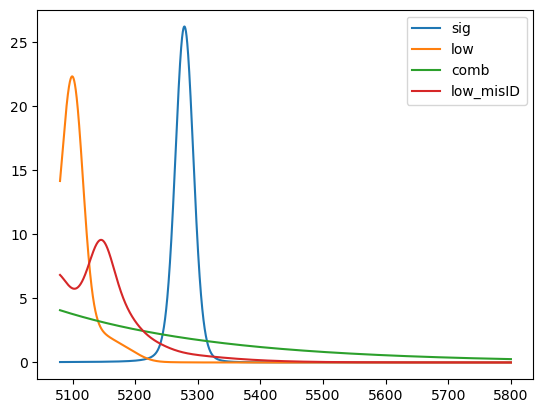

In [47]:
plt.plot(Bu_M, pdf['sig'](Bu_M)*1000, label='sig')
plt.plot(Bu_M, pdf['low'](Bu_M)*1000, label='low')
plt.plot(Bu_M, pdf['comb'](Bu_M)*1000, label='comb')
plt.plot(Bu_M, pdf['low_misID'](Bu_M)*1000, label='low_misID')
plt.legend()